# Module Requirements

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf

In [2]:
import cv2
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D # 나중에 Dropout 추가
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Dataset

In [3]:
path = "./data/Face Mask Dataset/"
dataset = {"image_path": [], "mask_status": [], "where": []}

for where in os.listdir(path):  # path 경로에서 요소를 하나씩 where 변수로 가져오기. (여기서는 Test, Train, Validation 폴더)
    for status in os.listdir(path + "/" + where):   # 각 폴더 안에 하위 폴더를 status에 변수로 가져오기. (여기서는 WithMask, WithoutMask). 즉, 라벨
        for image in glob.glob(path + where + "/" + status + "/" + "*.png"):    # 해당 폴더 안에 모든 .png 파일명을 하나씩 image변수로 가져오기.
            dataset['image_path'].append(image)     # 데이터셋 딕셔너리의 키값 "image_path"의 value로 사진 파일 경로를 저장
            dataset['mask_status'].append(status)   # 데이터셋 딕셔너리의 키값 "mask_status"의 value로 라벨이 되는 폴더명을 저장.
            dataset["where"].append(where)          # 데이터셋 딕셔너리의 키값 "where"의 value로 해당 데이터 카테고리로 사용되는 폴더명 저장.

dataset = pd.DataFrame(dataset)
dataset.head()

,image_path,mask_status,where
0,./data/Face Mask Dataset/Test/WithMask\1163.png,WithMask,Test
1,./data/Face Mask Dataset/Test/WithMask\1174.png,WithMask,Test
2,./data/Face Mask Dataset/Test/WithMask\1175.png,WithMask,Test
3,./data/Face Mask Dataset/Test/WithMask\1203.png,WithMask,Test
4,./data/Face Mask Dataset/Test/WithMask\1361.png,WithMask,Test


In [4]:
print("With Mask:", dataset.value_counts("mask_status")[0])
print("Without Mask:", dataset.value_counts("mask_status")[1])

With Mask: 5909
Without Mask: 5883


# Preprocessing

In [5]:
train_df = dataset[dataset["where"] == "Train"]
test_df = dataset[dataset["where"] == "Test"]
valid_df = dataset[dataset["where"] == "Validation"]

# Index Reset
train_df = train_df.reset_index().drop("index", axis=1)

In [6]:
data = []
image_size = 150

for i in range(len(train_df)):
    # Converting the image into grayscale.
    img_array = cv2.imread(train_df["image_path"][i], cv2.IMREAD_GRAYSCALE)

    # Resizing the array
    new_image_array = cv2.resize(img_array, (image_size, image_size))

    # Encoding the image with the label
    if train_df["mask_status"][i] == "WithMask":
        data.append([new_image_array, 1])
    else:
        data.append([new_image_array, 0])

In [7]:
np.random.shuffle(data)

In [8]:
X = []
y = []

for image in data:
    X.append(image[0])
    y.append(image[1])

X = np.array(X)
y = np.array(y)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

# Modeling

In [10]:
from tensorflow.keras import layers, models

model = models.Sequential(
    [
        Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding="same", activation='relu', input_shape=(150, 150, 1)),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(64, (2, 2), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2,)),
        layers.Dropout(0.25),
        Flatten(),
        Dense(1000, activation='relu'),
        Dense(1, activation='sigmoid')
    ]
)

- compile

In [11]:
model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

## Train

In [13]:
# 학습 환경

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15142953871056525409
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2249929524
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12481628441136237950
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [12]:
X_train = X_train.reshape(len(X_train), X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(len(X_val), X_val.shape[1], X_val.shape[2], 1)
history = model.fit(X_train, y_train, epochs=4, batch_size=32)

Epoch 1/4
250/250 [==============================] - 24s 78ms/step - loss: 49.8786 - accuracy: 0.8725
Epoch 2/4
250/250 [==============================] - 21s 83ms/step - loss: 0.0818 - accuracy: 0.9694
Epoch 3/4
250/250 [==============================] - 20s 81ms/step - loss: 0.0362 - accuracy: 0.9874
Epoch 4/4
250/250 [==============================] - 20s 81ms/step - loss: 0.0214 - accuracy: 0.9925


# 성능 평가

In [13]:
prediction = (model.predict(X_val) > 0.5).astype("int32")

print(classification_report(y_val, prediction))
print(confusion_matrix(y_val, prediction))

63/63 [==============================] - 2s 24ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1031
           1       0.97      0.97      0.97       969

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

[[1006   25]
 [  26  943]]


In [17]:
wrong_result = []

for n in range(0, len(y_val)):
    if prediction[n] != y_val[n]:
        wrong_result.append(n)
        
len(wrong_result)

51

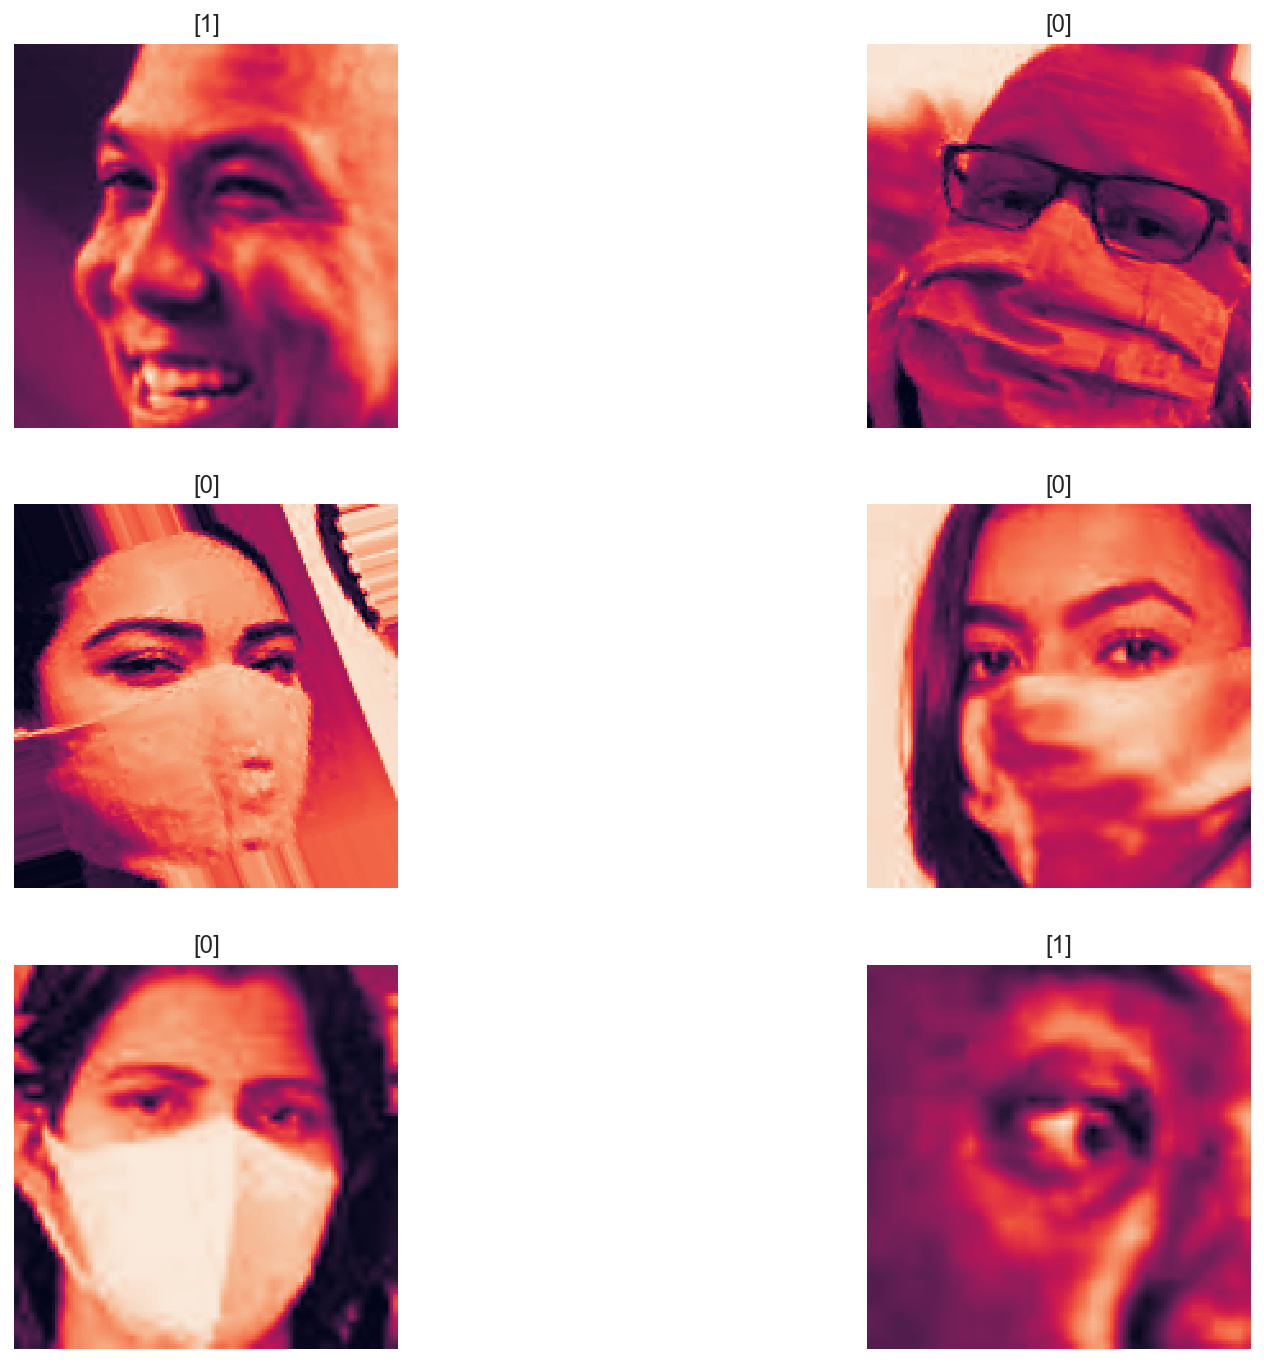

In [19]:
import random

samples = random.choices(population=wrong_result, k=6)

plt.figure(figsize=(14, 12))

for idx, n in enumerate(samples):
    plt.subplot(3, 2, idx + 1)
    plt.imshow(X_val[n].reshape(150, 150), interpolation='nearest')
    plt.title(prediction[n])
    plt.axis("off")
    
plt.show()

- FP 특징: 팔자 주름이 진하거나 수염으로 인해 얼굴에 경계가 생긴 경우로 추정
- FN 특징: 마스크가 요란하여 얼굴과 명확한 경계를 인식하지 못하는 경우로 추정

# 자체 데이터 Test

In [170]:
path2 = "./data/Mask Man Test/"
dataset2 = {"image_path": [], "mask_status": [], "where": []}

for status in os.listdir(path2):   # 각 폴더 안에 하위 폴더를 status에 변수로 가져오기. (여기서는 WithMask, WithoutMask). 즉, 라벨
    for image in glob.glob(path2 + status + "/" + "*.png"):    # 해당 폴더 안에 모든 .png 파일명을 하나씩 image변수로 가져오기.
        dataset2['image_path'].append(image)     # 데이터셋 딕셔너리의 키값 "image_path"의 value로 사진 파일 경로를 저장
        dataset2['mask_status'].append(status)   # 데이터셋 딕셔너리의 키값 "mask_status"의 value로 라벨이 되는 폴더명을 저장.
        dataset2["where"].append("OwnData")          # 데이터셋 딕셔너리의 키값 "where"의 value로 해당 데이터 카테고리로 사용되는 폴더명 저장.

dataset2 = pd.DataFrame(dataset2)
dataset2

,image_path,mask_status,where
0,./data/Mask Man Test/WithMask\Baek Mask.png,WithMask,OwnData
1,./data/Mask Man Test/WithMask\Mask JS.png,WithMask,OwnData
2,./data/Mask Man Test/WithMask\Mask Sam 01.png,WithMask,OwnData
3,./data/Mask Man Test/WithoutMask\Baek NM.png,WithoutMask,OwnData
4,./data/Mask Man Test/WithoutMask\NM Sam 0.png,WithoutMask,OwnData
5,./data/Mask Man Test/WithoutMask\NM Yoo.png,WithoutMask,OwnData


In [171]:
data2 = []
image_size = 150

for i in range(len(dataset2)):
    # Converting the image into grayscale.
    img_array = cv2.imread(dataset2["image_path"][i], cv2.IMREAD_GRAYSCALE)

    # Resizing the array
    new_image_array = cv2.resize(img_array, (image_size, image_size))

    # Encoding the image with the label
    if dataset2["mask_status"][i] == "WithMask":
        data2.append([new_image_array, 1])
    else:
        data2.append([new_image_array, 0])

In [172]:
X_own = []
y_own = []

for image in data2:
    X_own.append(image[0])
    y_own.append(image[1])

X_own = np.array(X_own)
y_own = np.array(y_own)

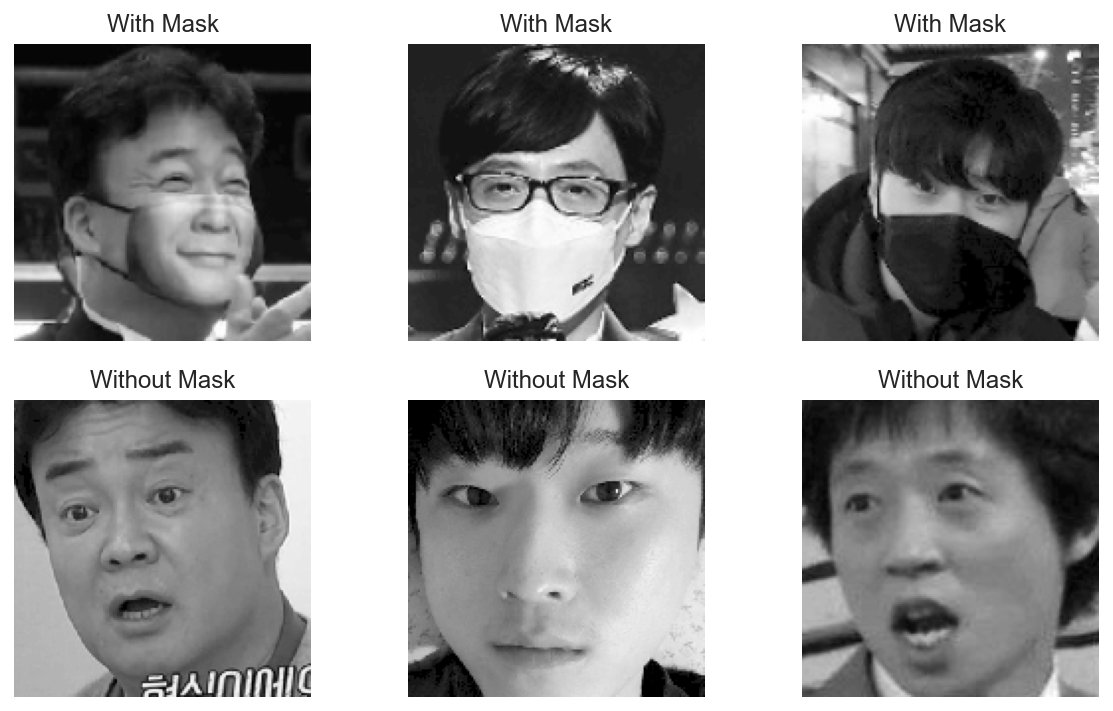

In [173]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))

image_index = 0
for row in range(2):
    for col in range(3):

        ax[row, col].axis("off")
        ax[row, col].imshow(data2[image_index][0], cmap="gray")

        if data2[image_index][1] == 0:
            ax[row, col].set_title("Without Mask")
        else:
            ax[row, col].set_title("With Mask")
        
        image_index += 1

In [174]:
X_own = X_own.reshape(len(X_own), X_own.shape[1], X_own.shape[2], 1)

In [175]:
prediction = (model.predict(X_own) > 0.6).astype("int32")   # 팔자주름까지 지나치게 마스크로 인식하는 경향이 있어서 임의로 0.6 기준으로 설정
prediction

1/1 [==============================] - 0s 30ms/step


array([[1],
       [1],
       [1],
       [0],
       [0],
       [0]])

In [176]:
prediction = (model.predict(X_own) > 0.6).astype("int32")

print(classification_report(y_own, prediction))
print(confusion_matrix(y_own, prediction))

1/1 [==============================] - 0s 24ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

[[3 0]
 [0 3]]


In [179]:
right_result = []

for n in range(0, len(y_own)):
    if prediction[n] == y_own[n]:
        right_result.append(n)
        
len(right_result)

6

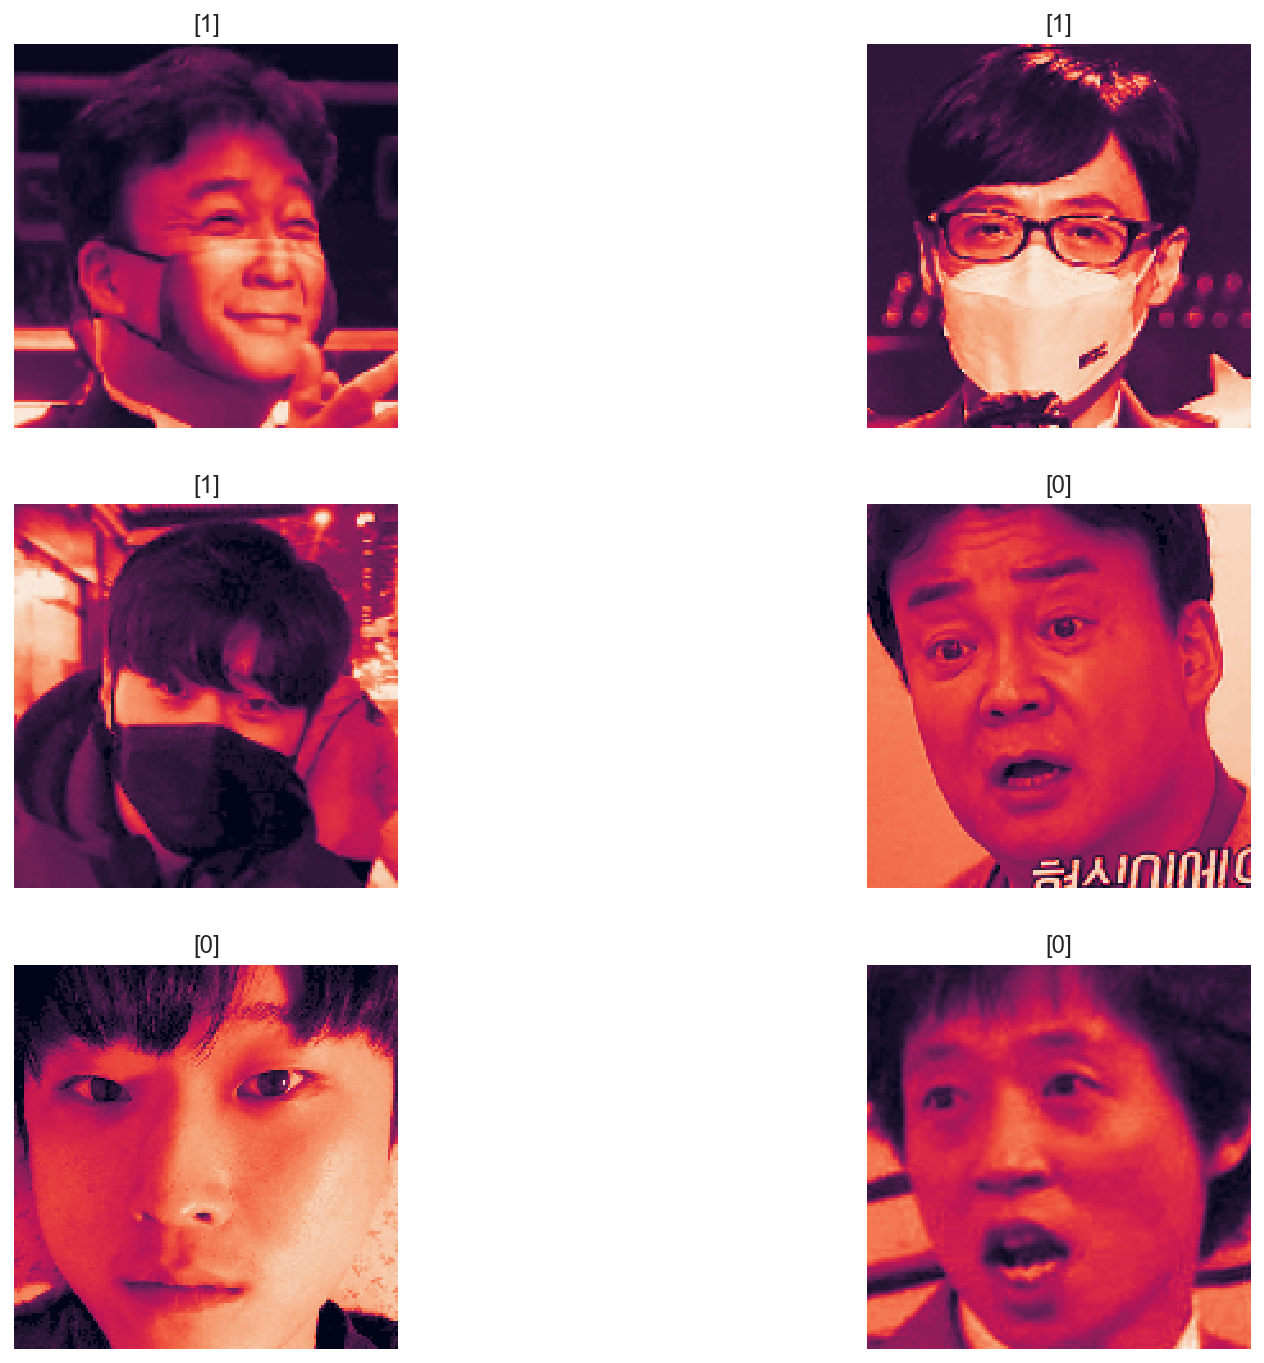

In [181]:
plt.figure(figsize=(14, 12))

for idx, n in enumerate(right_result):
    plt.subplot(3, 2, idx + 1)
    plt.imshow(X_own[n].reshape(150, 150), interpolation='nearest')
    plt.title(prediction[n])
    plt.axis("off")
    
plt.show()